In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data.csv').replace('-', np.NaN).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       2000 non-null   float64
 1   x       819 non-null    float64
 2   y       827 non-null    float64
dtypes: float64(3)
memory usage: 47.0 KB


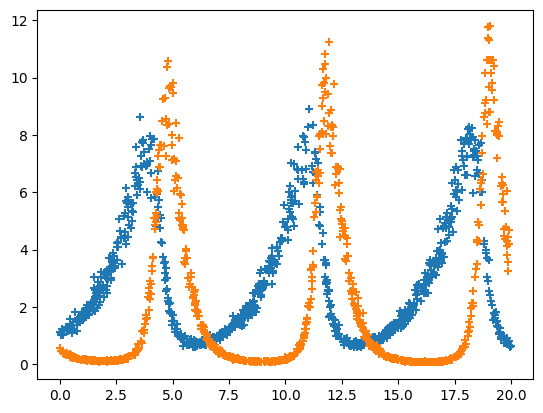

In [3]:
plt.scatter(x=df.t, y=df.x, marker='+')
plt.scatter(x=df.t, y=df.y, marker='+')
plt.show()

In [4]:
df_filled = df.interpolate(limit_direction='both')
df_filled

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
...,...,...,...
1995,19.95,0.611707,4.186361
1996,19.96,0.615469,4.186361
1997,19.97,0.619231,4.186361
1998,19.98,0.622993,4.186361


<AxesSubplot:xlabel='t'>

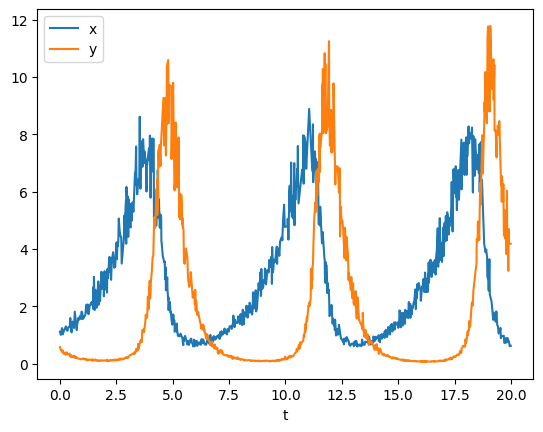

In [5]:
df_filled.plot(x='t', y=['x', 'y'])

# Linear NN

In [93]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [94]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(self.df_filled[['t']].values)
        self.y = torch.tensor(self.df_filled[['x', 'y']].values)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()

In [88]:
train = TimeSeriesDataset('data.csv')
X, y = train[0]
X.shape, y.shape

(torch.Size([1]), torch.Size([2]))

In [69]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[18.6700],
        [17.7000],
        [19.9100],
        [16.0900],
        [13.5800]])
torch.Size([5, 1])
tensor([[6.3407, 5.5559],
        [5.9110, 0.3260],
        [0.7463, 4.1864],
        [2.6787, 0.0855],
        [0.7556, 0.9085]])
torch.Size([5, 2])


In [95]:
BATCH_SIZE = 16

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.001

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [96]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 9.966
[1,    40] loss: 8.788
[1,    60] loss: 7.630
[1,    80] loss: 7.240
[1,   100] loss: 7.102
[1,   120] loss: 6.501
[2,    20] loss: 7.098
[2,    40] loss: 6.264
[2,    60] loss: 6.248
[2,    80] loss: 6.591
[2,   100] loss: 5.618
[2,   120] loss: 5.596
[3,    20] loss: 5.877
[3,    40] loss: 5.567
[3,    60] loss: 5.358
[3,    80] loss: 5.189
[3,   100] loss: 5.101
[3,   120] loss: 5.232
[4,    20] loss: 5.444
[4,    40] loss: 5.605
[4,    60] loss: 4.531
[4,    80] loss: 4.654
[4,   100] loss: 5.138
[4,   120] loss: 4.446
[5,    20] loss: 4.917
[5,    40] loss: 4.325
[5,    60] loss: 4.894
[5,    80] loss: 4.625
[5,   100] loss: 4.578
[5,   120] loss: 4.475
[6,    20] loss: 4.267
[6,    40] loss: 4.971
[6,    60] loss: 4.952
[6,    80] loss: 4.676
[6,   100] loss: 4.611
[6,   120] loss: 4.623
[7,    20] loss: 4.224
[7,    40] loss: 5.132
[7,    60] loss: 4.233
[7,    80] loss: 5.260
[7,   100] loss: 4.941
[7,   120] loss: 4.667
[8,    20] loss: 4.550
[8,    40] 

In [97]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.1092, 0.4655],
        [1.1109, 0.4562],
        [1.1126, 0.4469],
        ...,
        [0.6640, 3.8922],
        [0.6592, 3.8508],
        [0.6545, 3.8094]])

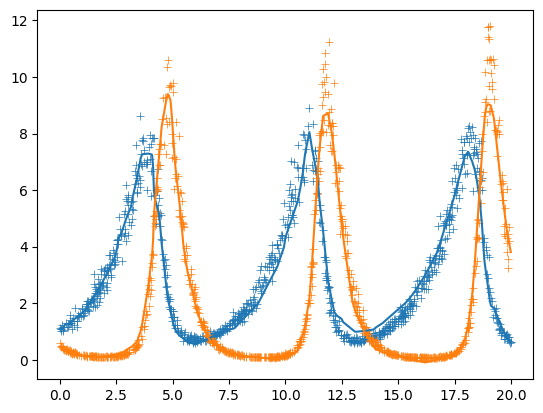

In [98]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

# Time Series LSTM

In [39]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.num_layers = 1
        self.hidden_units = 16
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [34]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(self.df_filled[['t']].values)
        self.y = torch.tensor(self.df_filled[['x', 'y']].values)
        self.seq_l = 7

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_l:
            i_start = idx - self.seq_l
            X = self.X[i_start:idx]
        else:
            padding = self.X[0].repeat(self.seq_l - idx, 1)
            X = self.X[0:idx]
            X = torch.cat((padding, X), 0)

        return X.float(), self.y[idx].float()

In [10]:
train = TimeSeriesDataset('data.csv')
X, y = train[4]
X, y

(tensor([[0.0000],
         [0.0000],
         [0.0100],
         [0.0200],
         [0.0300]]),
 tensor([1.0055, 0.4775]))

In [11]:
df_filled.head(9)

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
5,0.05,1.053657,0.468851
6,0.06,1.101832,0.460175
7,0.07,1.074546,0.465963
8,0.08,1.157007,0.471751


In [12]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[[16.3700],
         [16.3800],
         [16.3900],
         [16.4000],
         [16.4100]],

        [[ 2.9600],
         [ 2.9700],
         [ 2.9800],
         [ 2.9900],
         [ 3.0000]],

        [[ 8.4900],
         [ 8.5000],
         [ 8.5100],
         [ 8.5200],
         [ 8.5300]],

        [[10.0500],
         [10.0600],
         [10.0700],
         [10.0800],
         [10.0900]],

        [[10.4600],
         [10.4700],
         [10.4800],
         [10.4900],
         [10.5000]]])
torch.Size([5, 5, 1])
tensor([[3.5674, 0.0676],
        [5.1455, 0.1950],
        [1.8488, 0.1018],
        [5.0525, 0.1898],
        [6.6634, 0.4378]])
torch.Size([5, 2])


In [52]:
BATCH_SIZE = 8

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.001

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [53]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 11.149
[1,    40] loss: 13.344
[1,    60] loss: 10.721
[1,    80] loss: 10.766
[1,   100] loss: 7.774
[1,   120] loss: 8.039
[1,   140] loss: 6.730
[1,   160] loss: 6.774
[1,   180] loss: 7.615
[1,   200] loss: 5.856
[1,   220] loss: 5.785
[1,   240] loss: 6.054
[2,    20] loss: 7.180
[2,    40] loss: 6.624
[2,    60] loss: 6.135
[2,    80] loss: 7.034
[2,   100] loss: 6.751
[2,   120] loss: 6.805
[2,   140] loss: 5.725
[2,   160] loss: 6.351
[2,   180] loss: 5.991
[2,   200] loss: 6.941
[2,   220] loss: 5.937
[2,   240] loss: 6.283
[3,    20] loss: 6.608
[3,    40] loss: 7.099
[3,    60] loss: 6.692
[3,    80] loss: 6.243
[3,   100] loss: 6.024
[3,   120] loss: 6.033
[3,   140] loss: 6.574
[3,   160] loss: 6.770
[3,   180] loss: 6.271
[3,   200] loss: 5.607
[3,   220] loss: 5.379
[3,   240] loss: 5.690
[4,    20] loss: 6.512
[4,    40] loss: 5.684
[4,    60] loss: 5.618
[4,    80] loss: 6.167
[4,   100] loss: 5.671
[4,   120] loss: 5.955
[4,   140] loss: 5.716
[4,   1

In [54]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.0787, 0.4860],
        [1.0787, 0.4860],
        [1.0809, 0.4893],
        ...,
        [0.4740, 4.0157],
        [0.4636, 3.9767],
        [0.4532, 3.9387]])

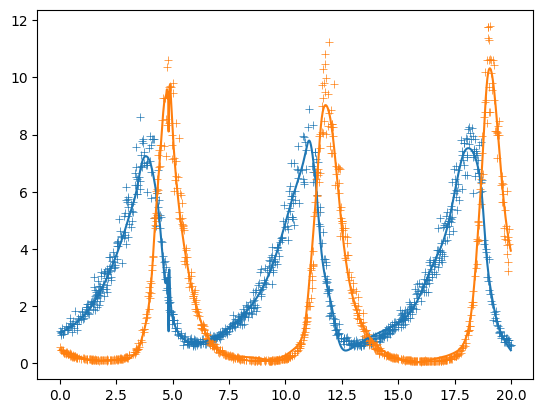

In [55]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

## Questions
Please answer the questions about the exercise below as a text cell. A few sentences answer per question is enough, no need to write a long essay.
  
- a) Roughly, how many parameters does the neural network you defined above have? How did you estimate that number?
- b) How does changing the batch size affect the optimization procedure?
- c) What optimizer did you choose and why? Explain its most important hyperparameters.
- d) What difficulties did you face when processing the dataset? How did you resolve them?
- e) How did you find the hyperparameters that gave you the best result? What would you have done if you had more time?
- f) In this exercise, we trained an MLP to regress the data from a single time point. This corresponds to assuming the source function is markovian. What would we do differently if the function under study were non-markovian?
- g) In this exercise, we did not check for overfitting. How would you change the code above to test for that possibility?
